**There are total of 3853 audio files in LAANA database.**

**In which 3625 are used for cross validation (CV) and remaining 228 (from folders H67, H68, H69 and P59, P60, P61) are for alien testing.**

**But when finding accuracies for age groups all 3853 are considered.**

Google Drive dysphasia dataset conntains all data, however test dataset is seprate

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Note: colab has changed the tensorflow version from 27 March 2020
import numpy as np
import pandas as pd
import pytz
import itertools
from operator import itemgetter
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from itertools import cycle
from datetime import datetime
from sklearn.utils import shuffle

# Machine Learning
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import KFold
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, classification_report, roc_curve, roc_auc_score, auc

# Deep Learning
import tensorflow as tf
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Input, Conv2D, MaxPooling2D, Dense, Dropout, Activation, Flatten
from keras.layers.normalization import BatchNormalization
from keras.callbacks import History, EarlyStopping, ModelCheckpoint, CSVLogger
from keras.models import load_model

In [ ]:
# Signal Processing Parameters
fs = 44100           # Sampling Frequency
n_fft = 2048         # length of the FFT window
hop_length = 812     # Number of samples between successive frames
testset_size = 0.25  # Percentage of data for Testing

In [ ]:
# Note: Label 0 => Healthy and 1=> Dysphasia

X = np.load('/content/drive/My Drive/saved_arrays/feature_vector_17_dec_2020_dysphasia.npy')
y = np.load('/content/drive/My Drive/saved_arrays/labels_17_dec_2020_dysphasia.npy')
X = np.array(X).astype('float32')

X, y = shuffle(X, y)
X, y = shuffle(X, y)
X, y = shuffle(X, y)
X, y = shuffle(X, y)

In [ ]:
# labelling Information, the code of this cell is updated and not executed
print('Note:> 0=> is healthy and 1=> is dysphasia \n')
unique_elements, counts_elements = np.unique(y, return_counts=True)
classes_array = np.asarray((unique_elements, counts_elements))
print(classes_array,'\n')
print("Total files are:", classes_array[1][0]+classes_array[1][1])

Note:> 0=> is healthy and 1=> is dysphasia 

[[   0    1]
 [1566 2059]] 

Total files are: 3625


In [ ]:
# building the mode
def get_model():
  model = Sequential()

  model.add(Conv2D(32, kernel_size=5, strides=1, activation='relu', input_shape=(1025,55,1)))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=2, strides=2))
  model.add(Dropout(0.2))
  
  model.add(Conv2D(64, (5, 5), activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.4))

  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(BatchNormalization())

  model.add(Dropout(0.5))
  model.add(Dense(2, activation='softmax'))
  # model.summary()
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

In [ ]:
get_model()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 1021, 51, 32)      832       
_________________________________________________________________
batch_normalization (BatchNo (None, 1021, 51, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 510, 25, 32)       0         
_________________________________________________________________
dropout (Dropout)            (None, 510, 25, 32)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 506, 21, 64)       51264     
_________________________________________________________________
batch_normalization_1 (Batch (None, 506, 21, 64)       256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 253, 10, 64)       0

In [ ]:
# confusion matrix drawing for each fold

def data_labelling(intLabel):
  Y = []
  length = len(intLabel)
  for i in range(length):
    if intLabel[i] == 0:
      Y.append("Healthy")
    elif intLabel[i] == 1:
      Y.append("Dysphasia")
  return Y

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        
    figure(num=None, figsize=(8, 6), dpi=120, facecolor='w', edgecolor='red')
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig('/content/drive/My Drive/saveModels/dysphasia/cnf_mat/'+title+'.png', bbox_inches='tight')

def cnf_matrix_for_each_fold(model, testX, testY, fold_no):
  y_pred = model.predict(testX)
  y_pred = np.rint(y_pred.argmax(axis=1))
  y_pred = y_pred.tolist()
  testY = np.rint(testY)
  testY = testY.tolist()

  y_true = data_labelling(testY)
  y_predicted = data_labelling(y_pred)

  cnf_matrix = confusion_matrix(y_true, y_predicted, labels=['Healthy', 'Dysphasia'])
  np.set_printoptions(precision=2)

  # Plot non-normalized confusion matrix
  plt.figure()
  plot_confusion_matrix(cnf_matrix, classes=['Healthy', 'Dysphasia'], title='Confusion matrix for fold No._'+ str(fold_no))

In [ ]:
# Plotting and estimation of FPR, TPR for ROC

def draw_roc(model, X_test, y_test, fold_no):
  y_pred = model.predict(X_test)
  y_true = y_test
  y_true = y_true.astype(int)
  n_classes = y_test.shape[1]
  fpr = dict()
  tpr = dict()
  roc_auc = dict()

  for i in range(n_classes):
      fpr[i], tpr[i], thresholds = roc_curve(y_true[:, i], y_pred[:, i])
      roc_auc[i] = auc(fpr[i], tpr[i])
  colors = cycle(['green', 'red'])
  figure(num=None, figsize=(8, 6), dpi=120, facecolor='w', edgecolor='red')
  for i, color in zip(range(n_classes), colors):
      name = ['Helathy', 'Dysphasia']
      plt.plot(fpr[i], tpr[i], color=color, lw=1.5, label='{0} (Area under the curve =  {1:0.4f})' ''.format(name[i], roc_auc[i]))

  plt.plot([0, 1], [0, 1], 'k-', linestyle='--', lw=1.5)
  plt.xlim([-0.05, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic (ROC) curve for fold number '+ str(fold_no))
  plt.legend(loc="lower right")
  plt.savefig('/content/drive/My Drive/saveModels/dysphasia/ROC/ROC for fold no.'+str(fold_no)+'.png', bbox_inches='tight')
  plt.show()

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 00026: early stopping
Score for fold 1: loss of 0.2663266658782959; accuracy of 97.79614210128784% and training_loss: 0.22496198117733002; traing_acc: 98.34457635879517%
fold 1 training time is 0:03:11.973287
Confusion matrix, without normalization


<Figure size 432x288 with 0 Axes>

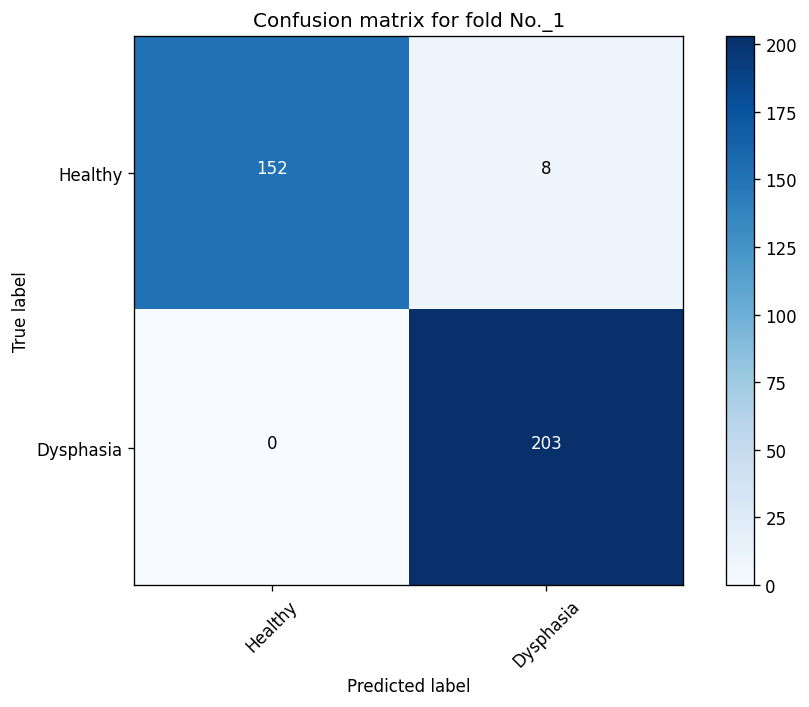

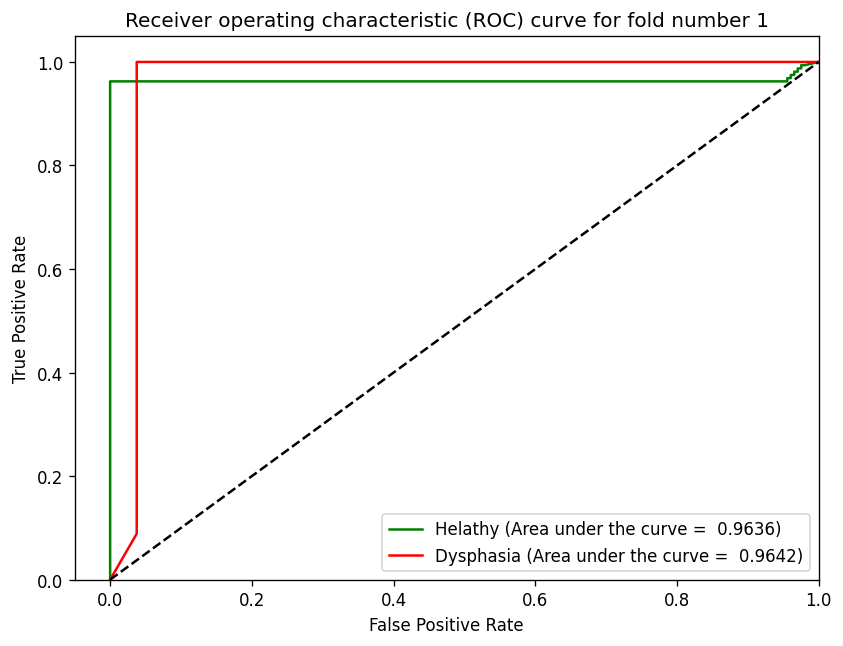

------------------------------------------------------------------------
Training for fold 2 ...
Epoch 00039: early stopping
Score for fold 2: loss of 0.0053889574483036995; accuracy of 99.7245192527771% and training_loss: 0.0005136177642270923; traing_acc: 100.0%
fold 2 training time is 0:04:44.043501
Confusion matrix, without normalization


<Figure size 432x288 with 0 Axes>

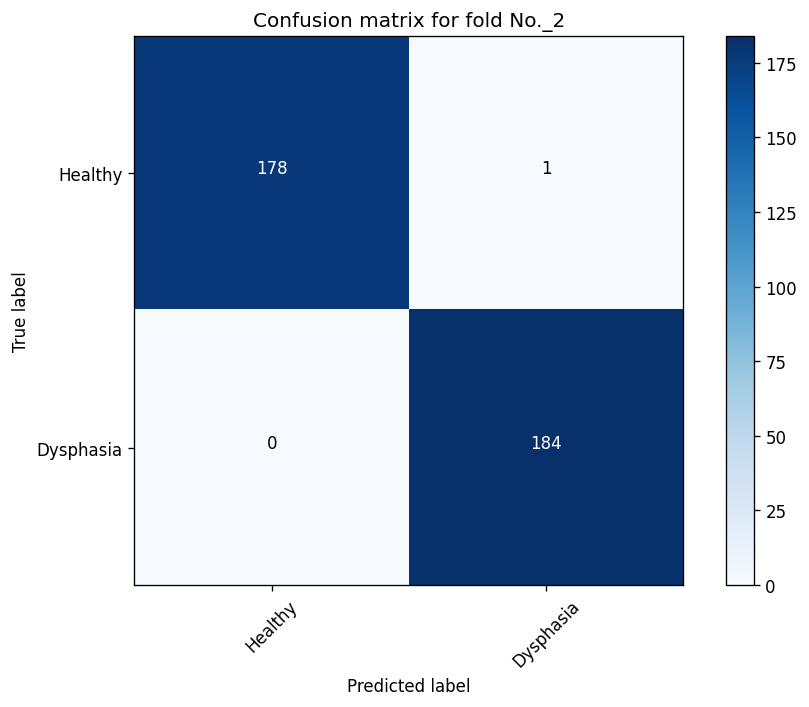

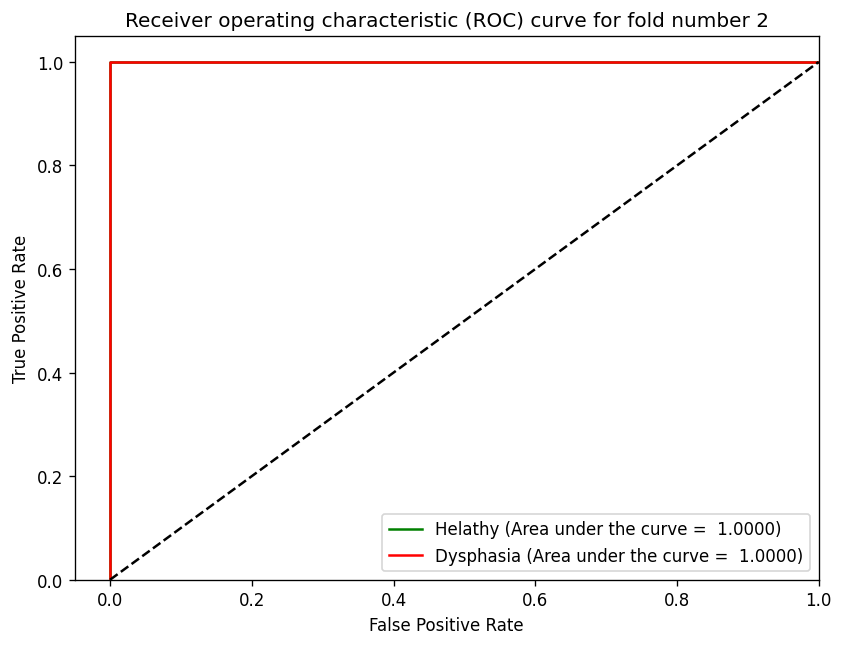

------------------------------------------------------------------------
Training for fold 3 ...
Epoch 00034: early stopping
Score for fold 3: loss of 0.03589797765016556; accuracy of 98.07162284851074% and training_loss: 0.04354039207100868; traing_acc: 98.12998175621033%
fold 3 training time is 0:04:08.727113
Confusion matrix, without normalization


<Figure size 432x288 with 0 Axes>

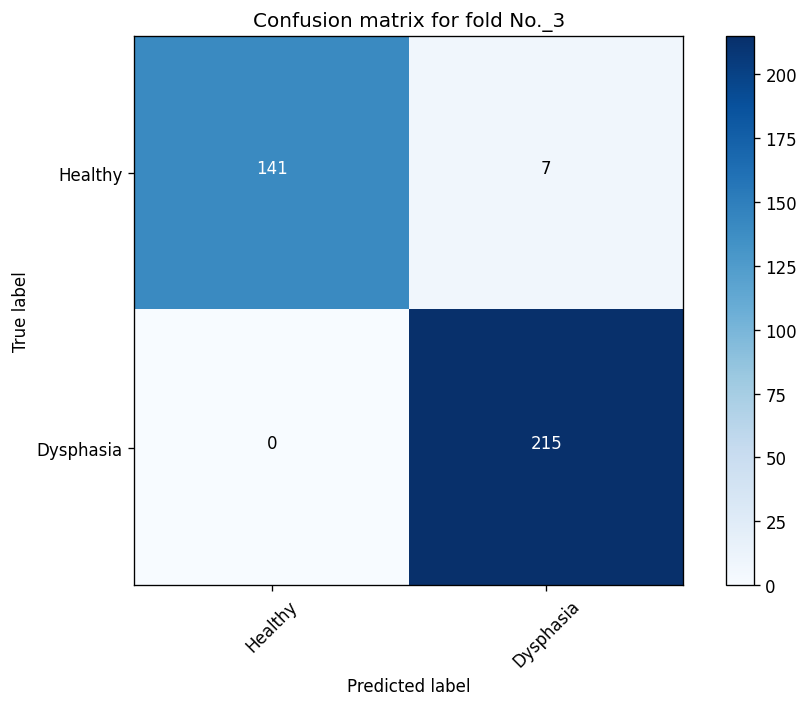

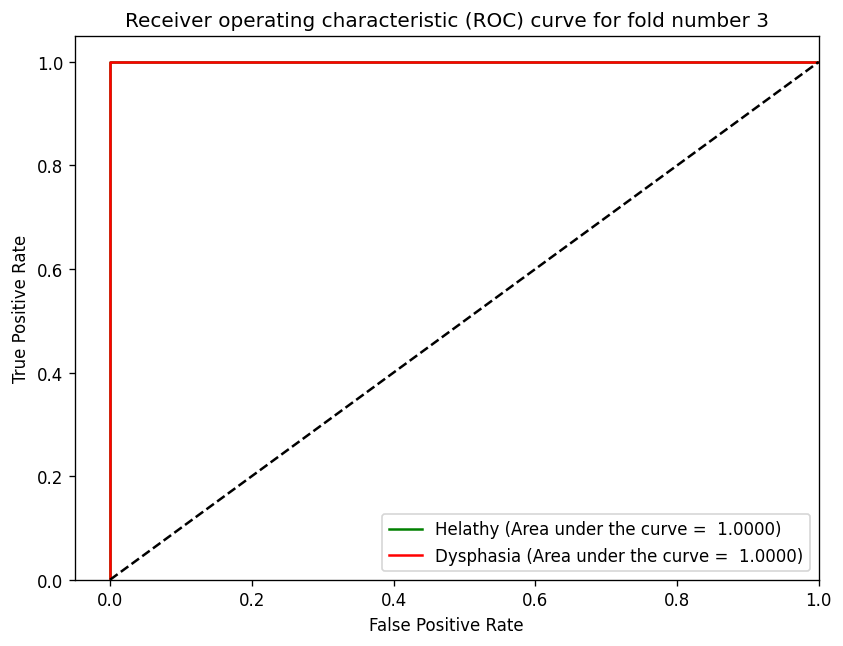

------------------------------------------------------------------------
Training for fold 4 ...
Epoch 00041: early stopping
Score for fold 4: loss of 0.10921984910964966; accuracy of 98.62259030342102% and training_loss: 0.011558888480067253; traing_acc: 99.90803003311157%
fold 4 training time is 0:04:58.126386
Confusion matrix, without normalization


<Figure size 432x288 with 0 Axes>

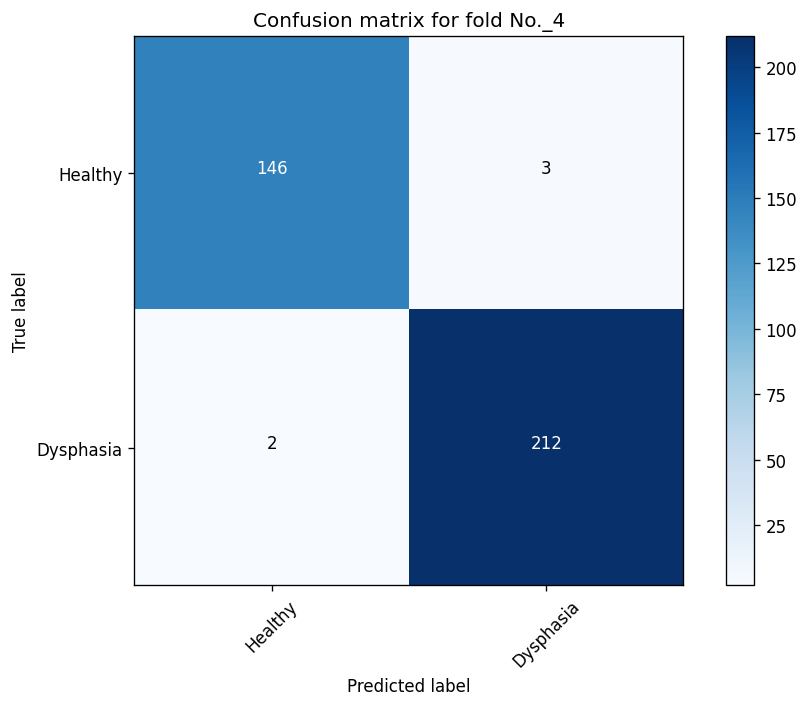

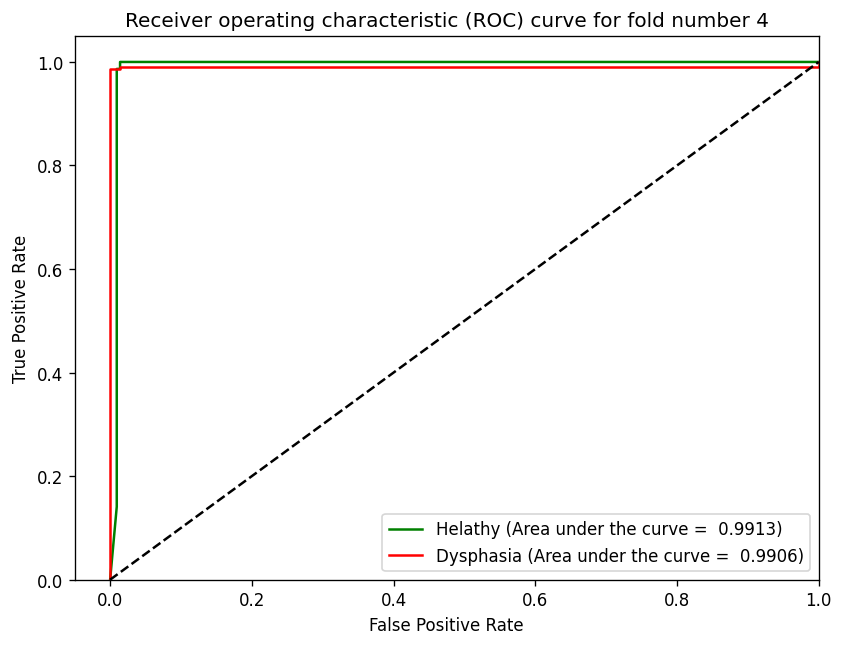

------------------------------------------------------------------------
Training for fold 5 ...
Epoch 00041: early stopping
Score for fold 5: loss of 0.021231399849057198; accuracy of 99.17355179786682% and training_loss: 0.0019412282854318619; traing_acc: 99.90803003311157%
fold 5 training time is 0:05:02.102204
Confusion matrix, without normalization


<Figure size 432x288 with 0 Axes>

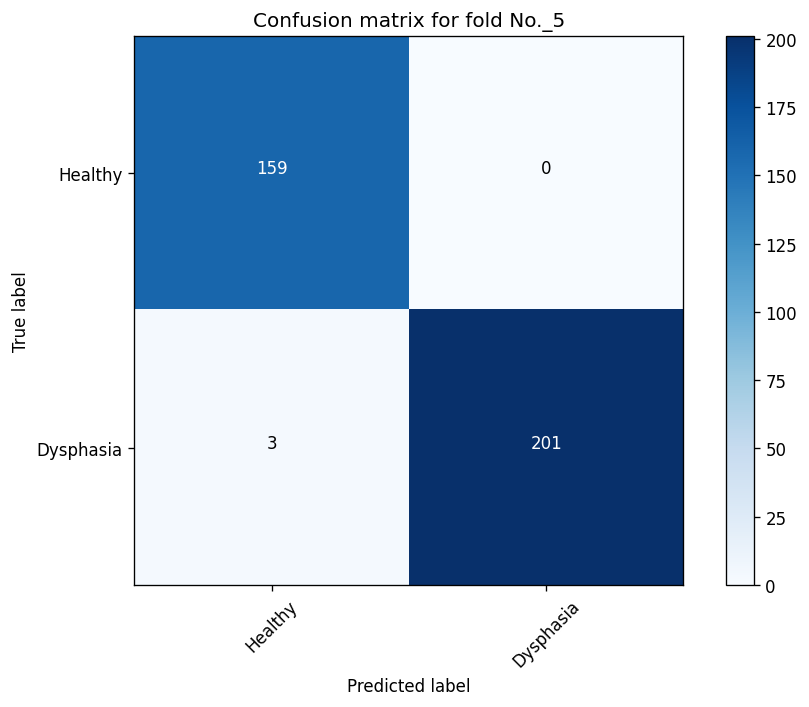

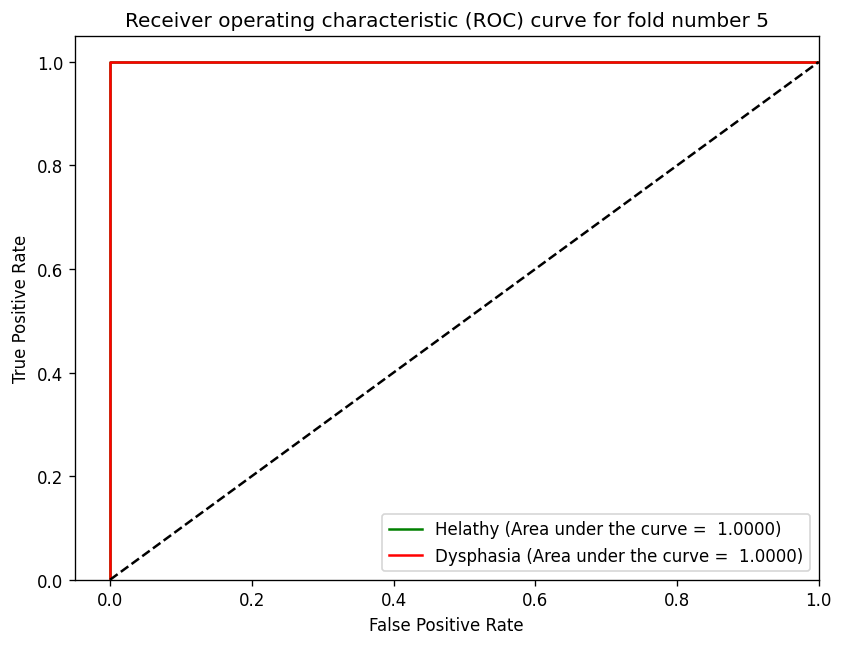

------------------------------------------------------------------------
Training for fold 6 ...
Epoch 00033: early stopping
Score for fold 6: loss of 0.006368146277964115; accuracy of 99.72375631332397% and training_loss: 0.00021617313905153424; traing_acc: 100.0%
fold 6 training time is 0:04:03.398943
Confusion matrix, without normalization


<Figure size 432x288 with 0 Axes>

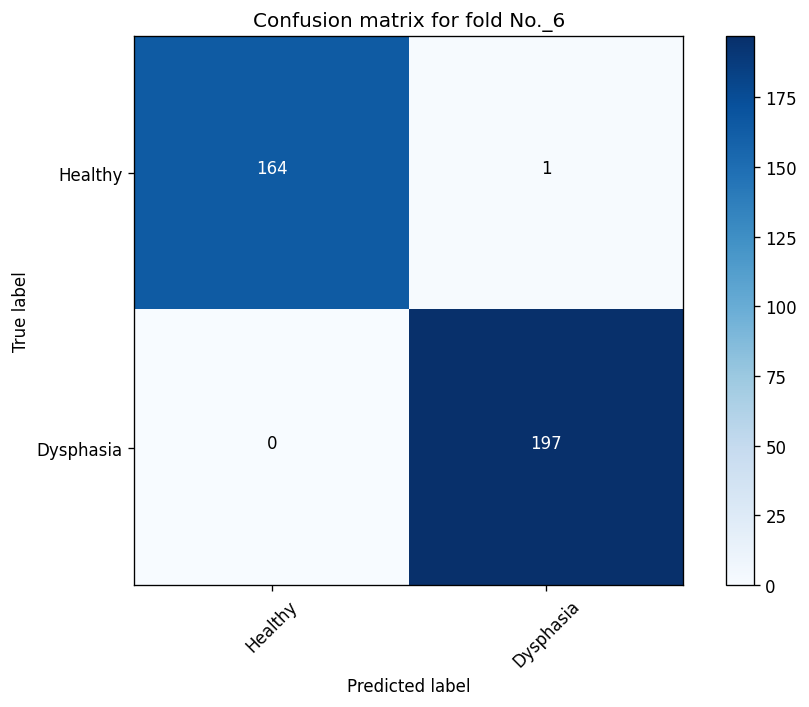

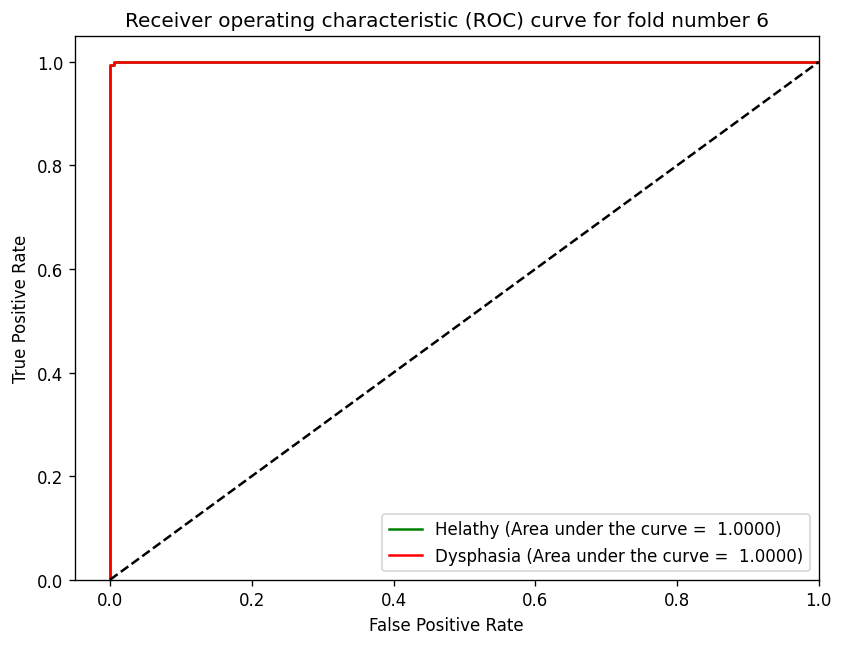

------------------------------------------------------------------------
Training for fold 7 ...
Epoch 00042: early stopping
Score for fold 7: loss of 0.007189611904323101; accuracy of 99.44751262664795% and training_loss: 0.0002297711616847664; traing_acc: 100.0%
fold 7 training time is 0:05:13.550513
Confusion matrix, without normalization


<Figure size 432x288 with 0 Axes>

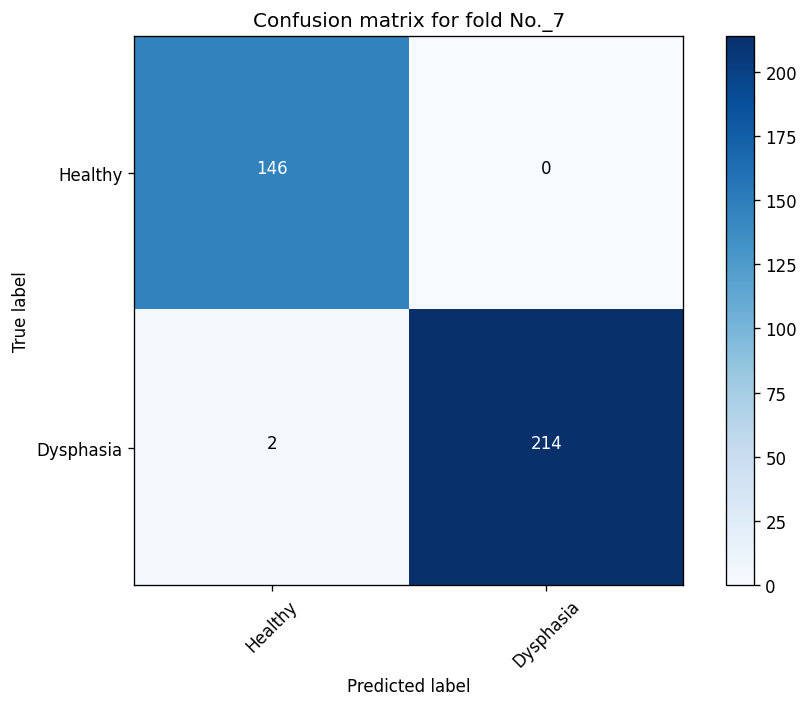

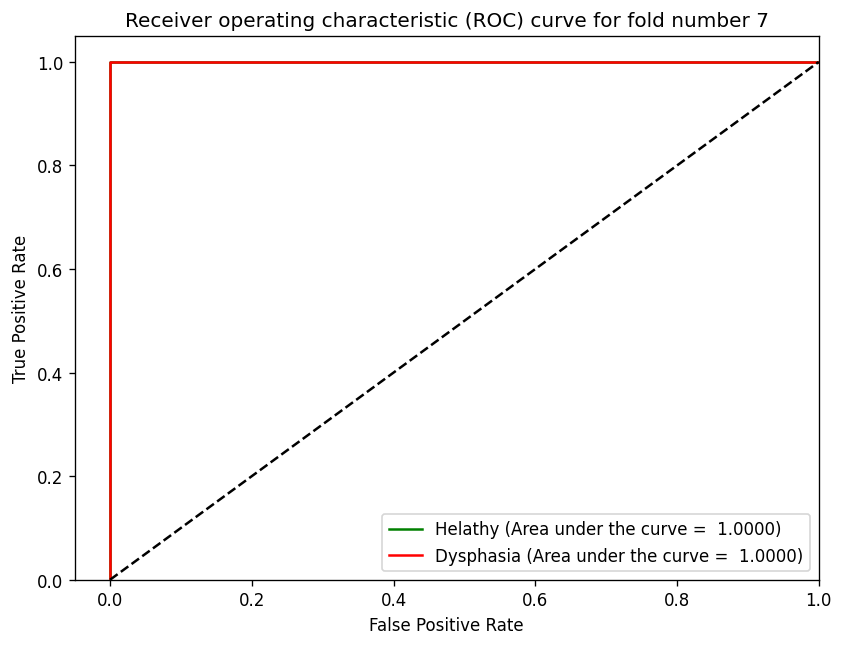

------------------------------------------------------------------------
Training for fold 8 ...
Epoch 00028: early stopping
Score for fold 8: loss of 0.02971101552248001; accuracy of 99.44751262664795% and training_loss: 0.023820890113711357; traing_acc: 99.41771626472473%
fold 8 training time is 0:03:32.123629
Confusion matrix, without normalization


<Figure size 432x288 with 0 Axes>

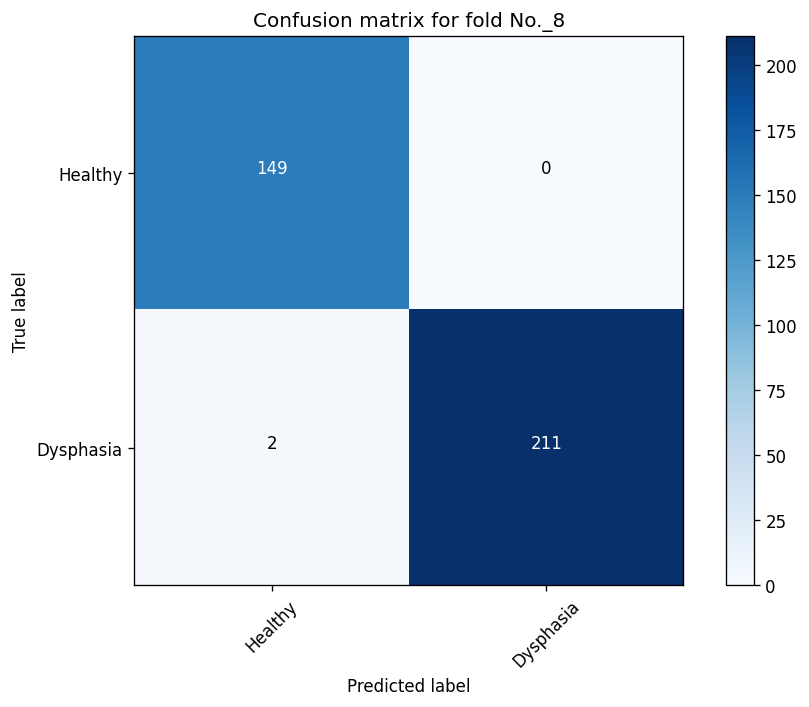

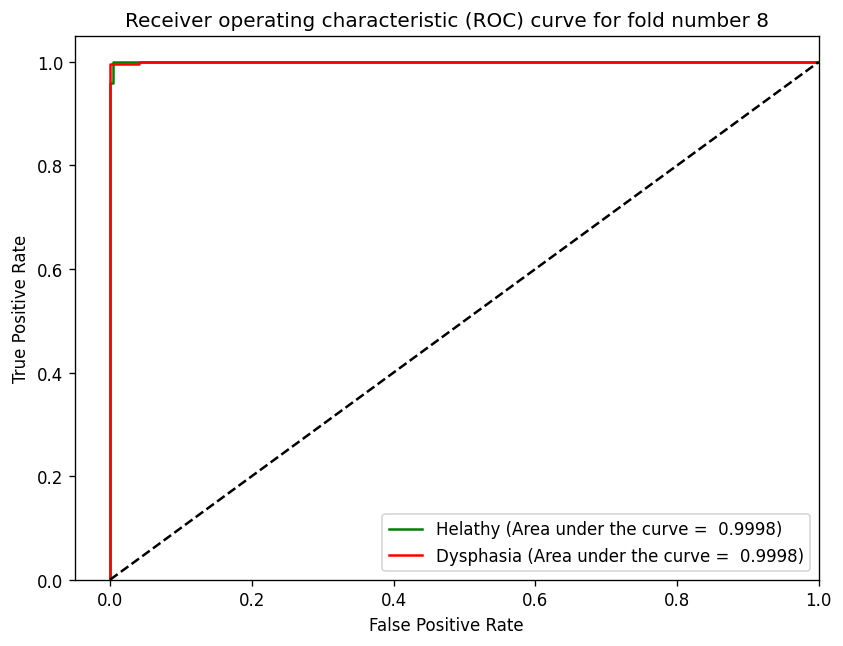

------------------------------------------------------------------------
Training for fold 9 ...
Epoch 00029: early stopping
Score for fold 9: loss of 0.013601640239357948; accuracy of 99.44751262664795% and training_loss: 0.003144745947793126; traing_acc: 99.87741112709045%
fold 9 training time is 0:03:35.291398
Confusion matrix, without normalization


<Figure size 432x288 with 0 Axes>

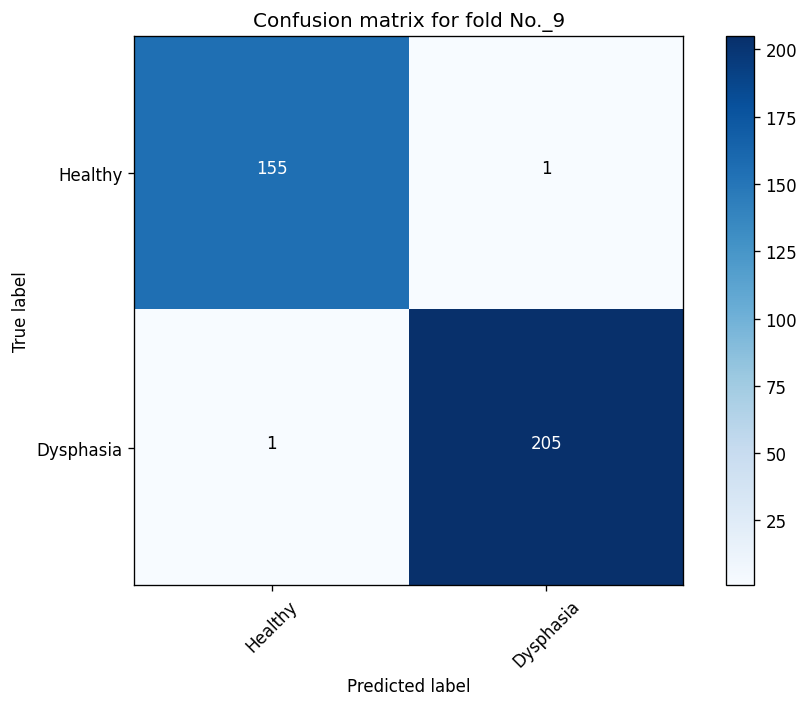

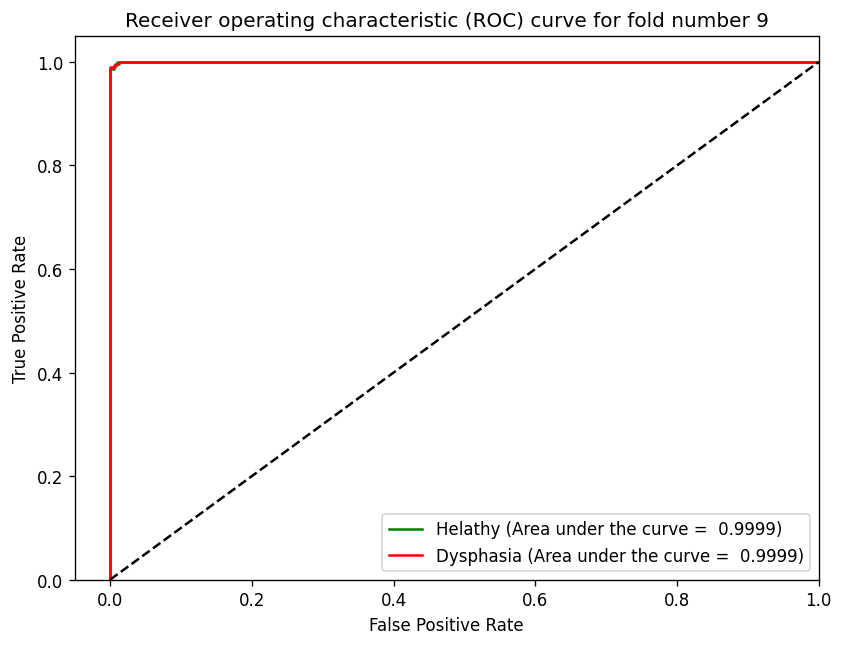

------------------------------------------------------------------------
Training for fold 10 ...
Epoch 00026: early stopping
Score for fold 10: loss of 0.024156633764505386; accuracy of 99.44751262664795% and training_loss: 0.00046093828859739006; traing_acc: 100.0%
fold 10 training time is 0:03:17.648874
Confusion matrix, without normalization


<Figure size 432x288 with 0 Axes>

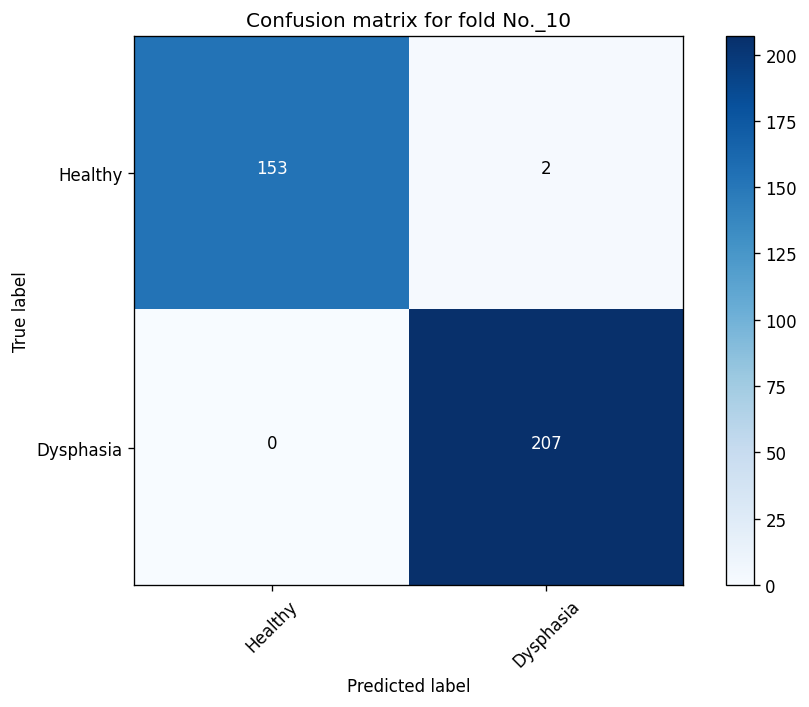

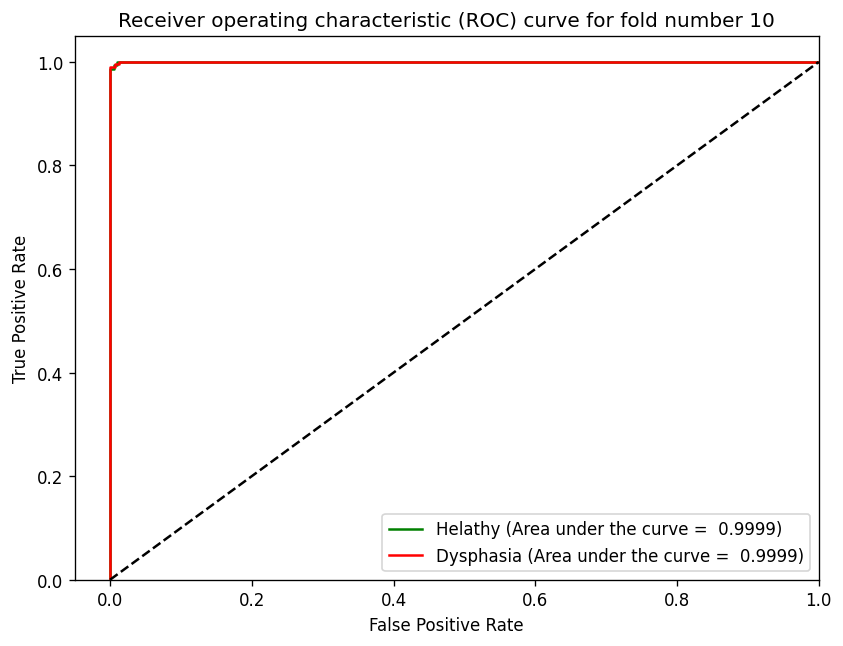

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.2663266658782959 - Accuracy: 97.79614210128784% - Training_Loss: 0.22496198117733002 - Training_Acc: 98.34457635879517%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.0053889574483036995 - Accuracy: 99.7245192527771% - Training_Loss: 0.0005136177642270923 - Training_Acc: 100.0%
------------------------------------------------------------------------
> Fold 3 - Loss: 0.03589797765016556 - Accuracy: 98.07162284851074% - Training_Loss: 0.04354039207100868 - Training_Acc: 98.12998175621033%
------------------------------------------------------------------------
> Fold 4 - Loss: 0.10921984910964966 - Accuracy: 98.62259030342102% - Training_Loss: 0.011558888480067253 - Training_Acc: 99.90803003311157%
---------------------------------------------------------------------

In [ ]:
# K-fold cross validation code, Updated 

batch_size = 32
no_epochs = 1000
num_folds = 10
fold_no = 1

# Define per-fold score containers
acc_per_fold  = []
loss_per_fold = []
train_acc_per_fold  = []
train_loss_per_fold = []
history_all_fold    = []

# Define the K-fold Cross Validator
kfold = KFold(n_splits=num_folds, shuffle=True)

last_fold_time = start = datetime.now()
for train, test in kfold.split(X, y):
  model = get_model()

  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')

  # time_stamp = datetime.now(pytz.timezone('Asia/Calcutta')).strftime("%m/%d/%Y, %H:%M:%S").replace(" ", "").replace("/", "-").replace(":", "-").replace(",", "_")
  modelPathSave = f'/content/drive/My Drive/saveModels/dysphasia/4.2_fold_{fold_no}.hdf5'
  pathToSaveCSV = f'/content/drive/My Drive/saveModels/dysphasia/csv/4.2_fold_{fold_no}.csv'
  checkpoint = ModelCheckpoint(modelPathSave, monitor='accuracy', verbose=0, save_best_only=True, save_weights_only=False, mode='auto')
  early_stop = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=20, verbose=1, mode='auto')
  csv_logger = CSVLogger(pathToSaveCSV, append=False, separator=',')

  steps = int(X[train].shape[0] / 32)
  history = model.fit(
              X[train], to_categorical(LabelEncoder().fit_transform(y[train])),
              batch_size= batch_size,
              epochs= no_epochs,
              callbacks = [checkpoint, csv_logger, early_stop],
              validation_data = (X[test], to_categorical(LabelEncoder().fit_transform(y[test]))),
              use_multiprocessing = True,
              # steps_per_epoch = steps,
              verbose=0)

  # Generate generalization metrics
  train_scores = model.evaluate(X[train], to_categorical(LabelEncoder().fit_transform(y[train])), verbose=0)
  val_scores = model.evaluate(X[test], to_categorical(LabelEncoder().fit_transform(y[test])), verbose=0)

  print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {val_scores[0]}; {model.metrics_names[1]} of {val_scores[1]*100}% and training_loss: {train_scores[0]}; traing_acc: {train_scores[1]*100}%')
  print(f'fold {fold_no} training time is {datetime.now() - last_fold_time}')
  last_fold_time = datetime.now()

  train_acc_per_fold.append(train_scores[1]*100)
  train_loss_per_fold.append(train_scores[0])
  acc_per_fold.append(val_scores[1] * 100)
  loss_per_fold.append(val_scores[0])
  history_all_fold.append(history.history)

  # call confusion matrix drawing function
  cnf_matrix_for_each_fold(model, X[test], y[test], fold_no)
  # ROC AUC drawing
  draw_roc(model, X[test], to_categorical(LabelEncoder().fit_transform(y[test])), fold_no)
  fold_no = fold_no + 1

duration = datetime.now() - start
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}% - Training_Loss: {train_loss_per_fold[i]} - Training_Acc: {train_acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Training Accuracy: {np.mean(train_acc_per_fold)} (+- {np.std(train_acc_per_fold)})')
print(f'> Training Loss: {np.mean(train_loss_per_fold)}')
print(f'> Validation Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Validation Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')
print("Training completed in time: ", duration)

In [ ]:
# traning and validation set sizes and respective healthy and dysphasia number of samples in each set

print(X.shape)
print(y.shape)

# K-fold cross validation code, Updated 
num_folds = 10
fold_no = 1
kfold = KFold(n_splits=num_folds, shuffle=True)

for train, test in kfold.split(X, y):
  print(f'fold {fold_no} training fold shape {train.shape} Validation fold shape {test.shape}')
  fold_no +=1

(3625, 1025, 55, 1)
(3625,)
fold 1 training fold shape (3262,) Validation fold shape (363,)
fold 2 training fold shape (3262,) Validation fold shape (363,)
fold 3 training fold shape (3262,) Validation fold shape (363,)
fold 4 training fold shape (3262,) Validation fold shape (363,)
fold 5 training fold shape (3262,) Validation fold shape (363,)
fold 6 training fold shape (3263,) Validation fold shape (362,)
fold 7 training fold shape (3263,) Validation fold shape (362,)
fold 8 training fold shape (3263,) Validation fold shape (362,)
fold 9 training fold shape (3263,) Validation fold shape (362,)
fold 10 training fold shape (3263,) Validation fold shape (362,)


**Saving Data for future time saving**

In [ ]:
# saving the data 

np.save('/content/drive/My Drive/saved_arrays/4.2_train_acc_per_fold.npy', train_acc_per_fold)
np.save('/content/drive/My Drive/saved_arrays/4.2_train_loss_per_fold.npy', train_loss_per_fold)
np.save('/content/drive/My Drive/saved_arrays/4.2_acc_per_fold.npy', acc_per_fold)
np.save('/content/drive/My Drive/saved_arrays/4.2_loss_per_fold.npy', loss_per_fold)
np.save('/content/drive/My Drive/saved_arrays/4.2_history_all_fold.npy', history_all_fold)

In [ ]:
# loading the data
# Note: all history files are deleted and not saved in google drive

load_train_acc_per_fold = np.load('/content/drive/My Drive/saved_arrays/4.2_train_acc_per_fold.npy')
load_train_loss_per_fold = np.load('/content/drive/My Drive/saved_arrays/4.2_train_loss_per_fold.npy')
load_acc_per_fold = np.load('/content/drive/My Drive/saved_arrays/4.2_acc_per_fold.npy')
load_loss_per_fold = np.load('/content/drive/My Drive/saved_arrays/4.2_loss_per_fold.npy')
load_history_all_fold = np.load('/content/drive/My Drive/saved_arrays/4.2_history_all_fold.npy', allow_pickle=True)

In [ ]:
from operator import itemgetter

loss =         list(map(itemgetter("loss"), load_history_all_fold))
val_loss =     list(map(itemgetter("val_loss"), load_history_all_fold))
accuracy =     list(map(itemgetter("accuracy"), load_history_all_fold))
val_accuracy = list(map(itemgetter("val_accuracy"), load_history_all_fold))

loss = [np.mean(i) for i in zip(*loss)]
val_loss = [np.mean(i) for i in zip(*val_loss)]
accuracy = [np.mean(i) for i in zip(*accuracy)]
val_accuracy = [np.mean(i) for i in zip(*val_accuracy)]

avg_history = {'loss':loss, 'val_loss':val_loss, 'accuracy':accuracy, 'val_accuracy':val_accuracy}
print(avg_history)

{'loss': [0.28567461520433424, 0.08050206862390041, 0.057194168120622633, 0.047787081077694894, 0.045986797846853736, 0.043875735718756914, 0.028837022185325623, 0.02468769866973162, 0.027467480720952155, 0.02229520808905363, 0.020309301698580383, 0.013368180254474282, 0.011085434025153518, 0.009092556522227823, 0.009947007242590188, 0.01060537132434547, 0.009802172926720231, 0.01561503594275564, 0.014715691935271025, 0.017099796049296855, 0.010332315060077235, 0.007629859587177634, 0.009180811973055824, 0.007034813973587006, 0.005111972289159894, 0.014161205876735038], 'val_loss': [6.635145795345307, 7.389597749710083, 5.951800417900086, 2.830241946876049, 0.6155724577605725, 0.13439870420843364, 0.08557349052280187, 0.138869296759367, 0.10254245148971677, 0.1802509899251163, 0.15115542309358715, 0.059453077428042886, 0.014367627701722086, 0.06040584900183603, 0.1389071589335799, 0.05182278531137854, 0.17287964113056659, 0.057935245474800466, 0.3260997039731592, 0.062070003699045626, 

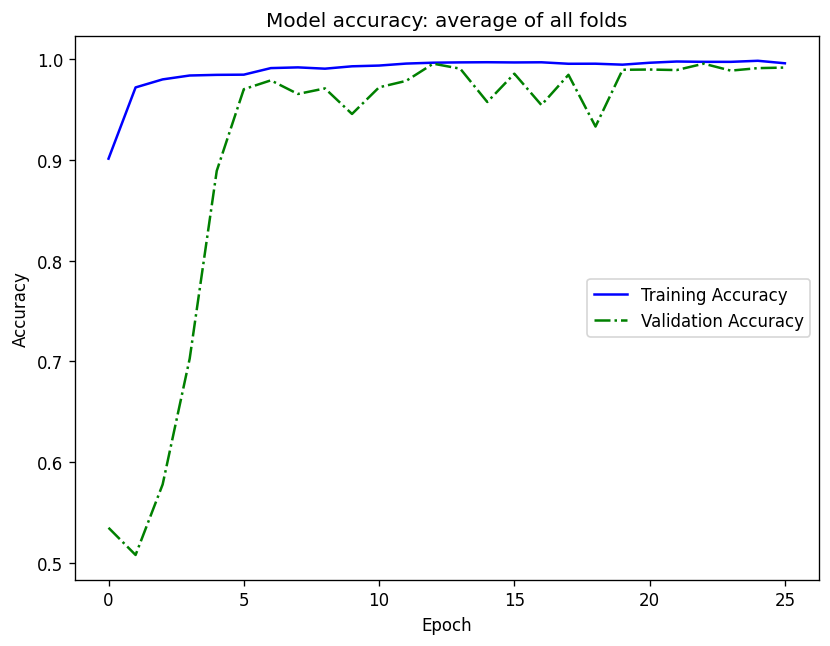

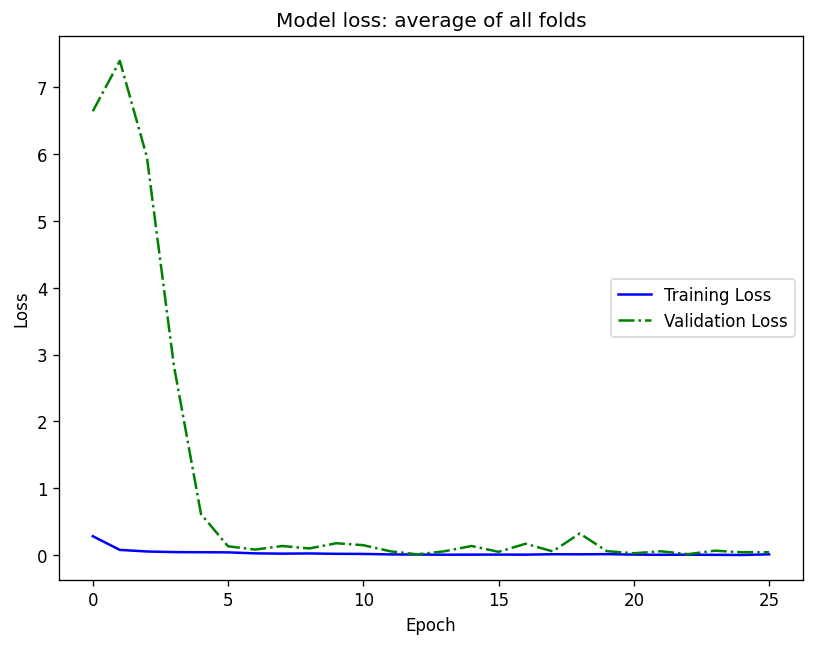

In [ ]:
# plot diagnostic learning curves, when dict history is saved without History object

def summarize_diagnostics(history, slug=""):
  # Plot training & validation accuracy values
  figure(num=None, figsize=(8, 6), dpi=120, facecolor='w', edgecolor='red')
  plt.plot(history['accuracy'], 'b')
  plt.plot(history['val_accuracy'], 'g', linestyle="-.")
  plt.title('Model accuracy'+slug)
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='center right')
  # plt.savefig('Accuracy'+slug+'.png', bbox_inches='tight')
  plt.show()

  # Plot training & validation loss values
  figure(num=None, figsize=(8, 6), dpi=120, facecolor='w', edgecolor='red')
  plt.plot(history['loss'], 'b')
  plt.plot(history['val_loss'], 'g', linestyle="-.")
  plt.title('Model loss'+slug)
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Training Loss', 'Validation Loss'], loc='center right')
  # plt.savefig('Loss'+slug+'.png', bbox_inches='tight')
  plt.show()

#--------------------------------------------------------------------------- learning curves
# print(history.history.keys())
# summarize_diagnostics(history)
# summarize_diagnostics(load_history_all_fold[5])
summarize_diagnostics(avg_history, ": average of all folds")

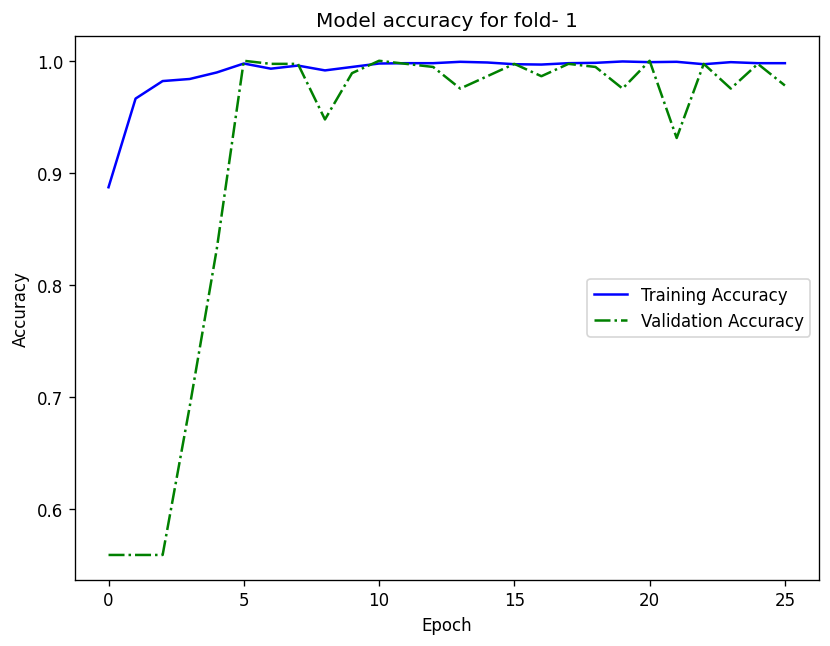

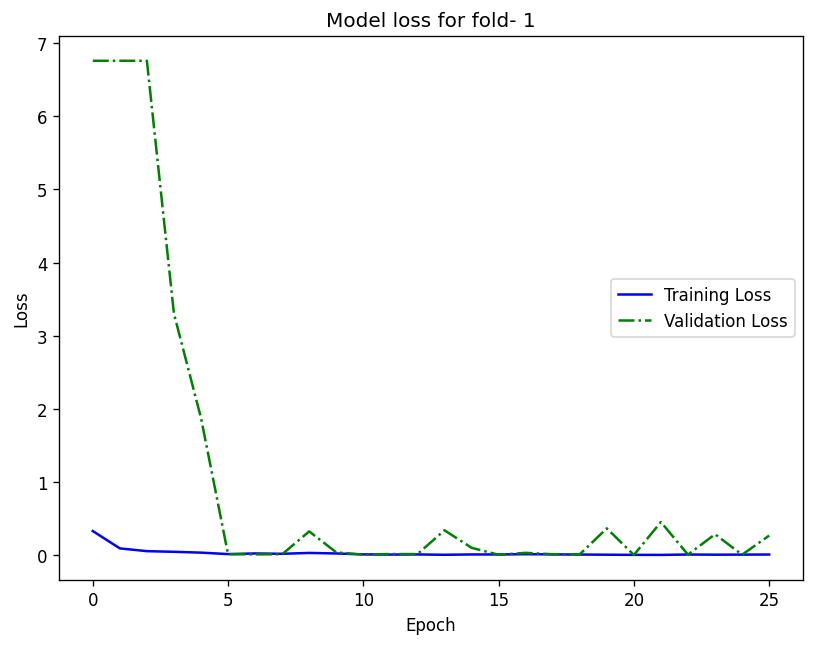

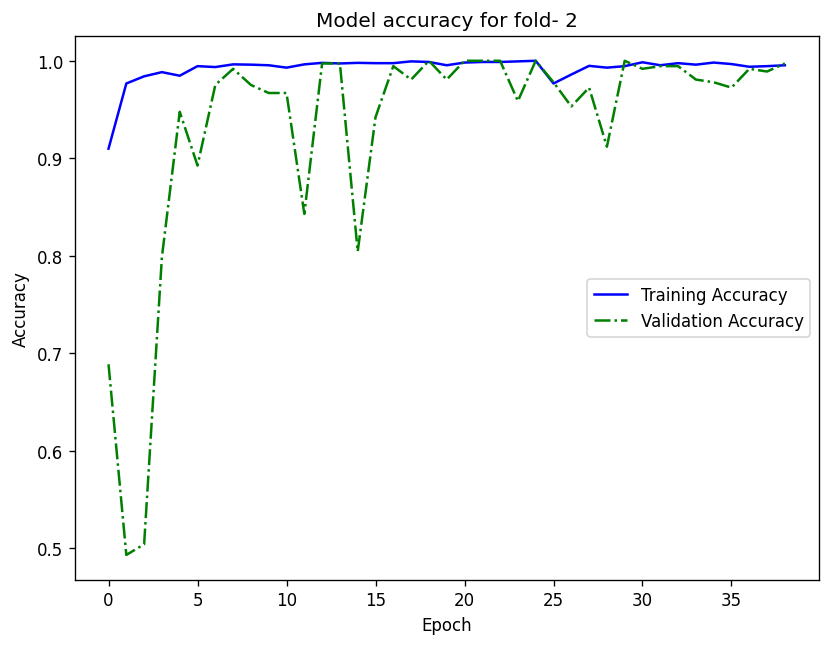

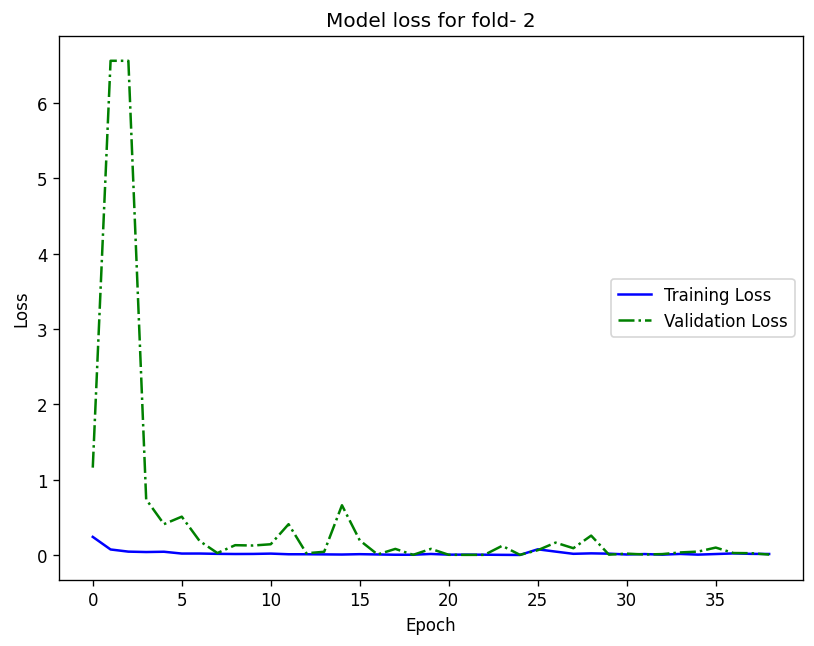

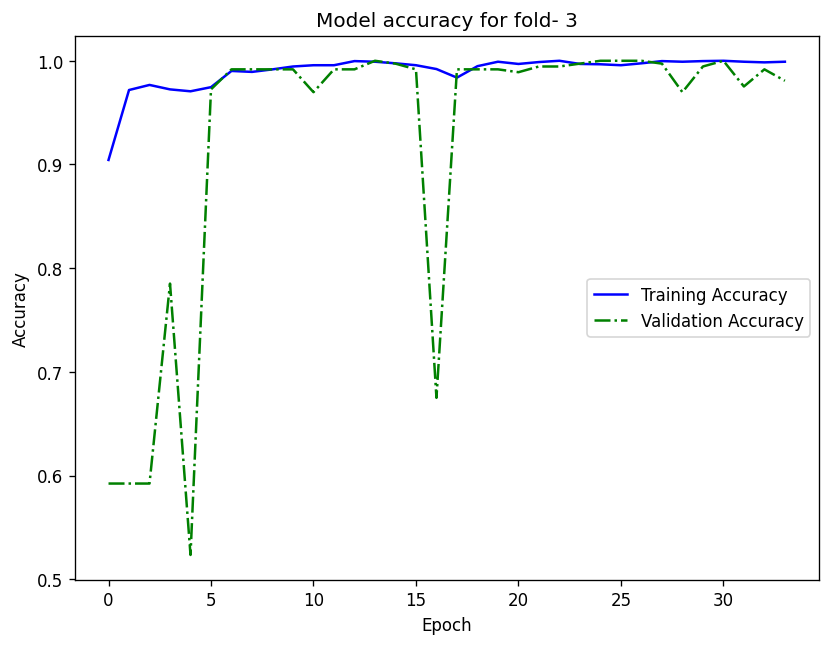

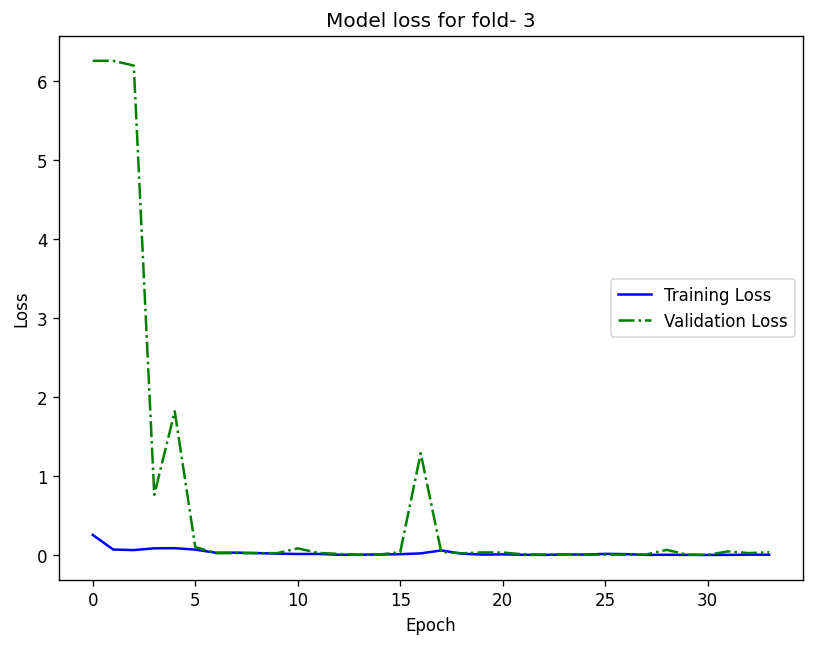

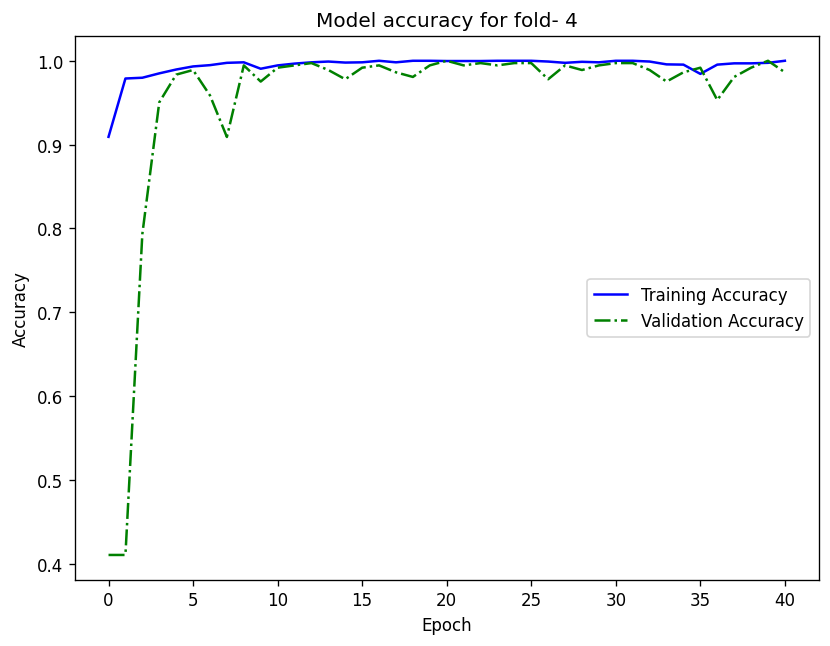

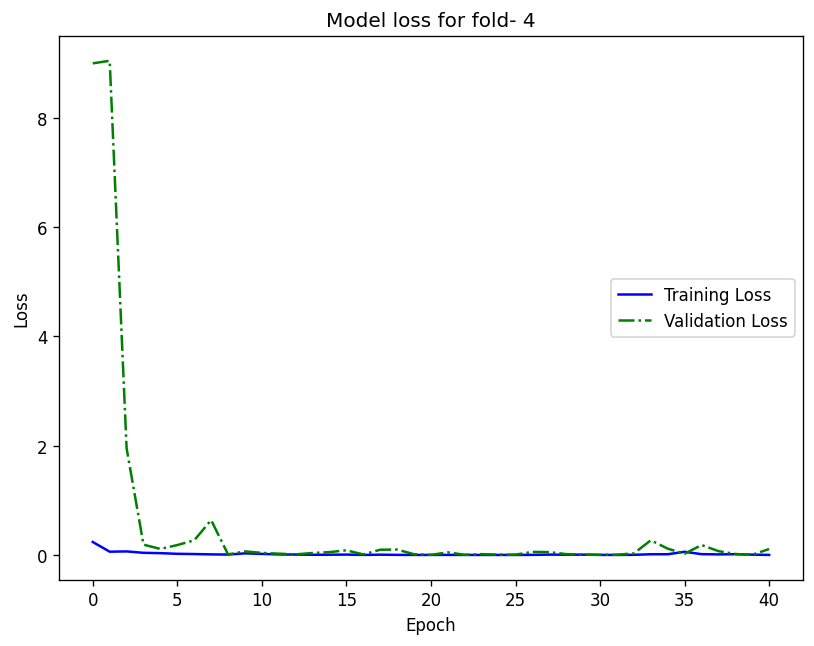

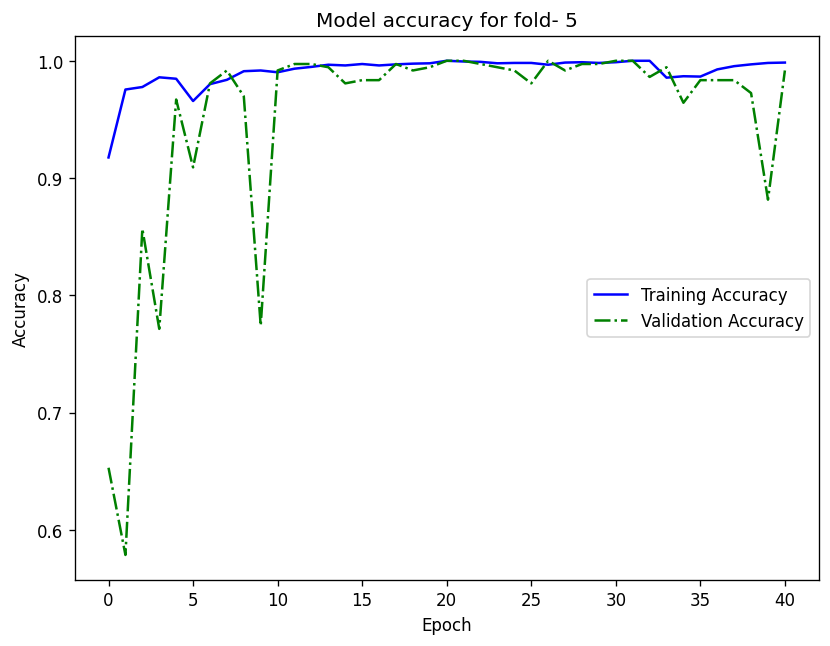

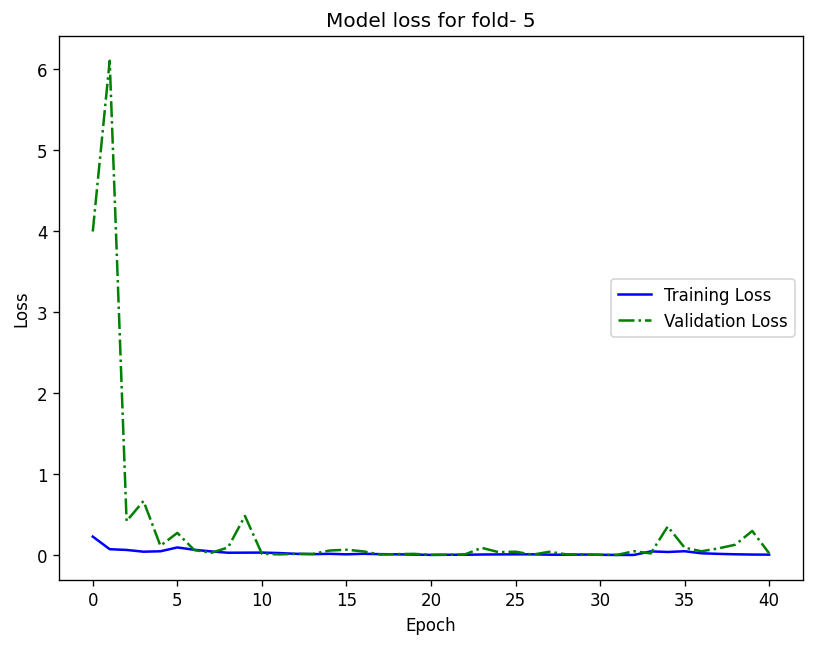

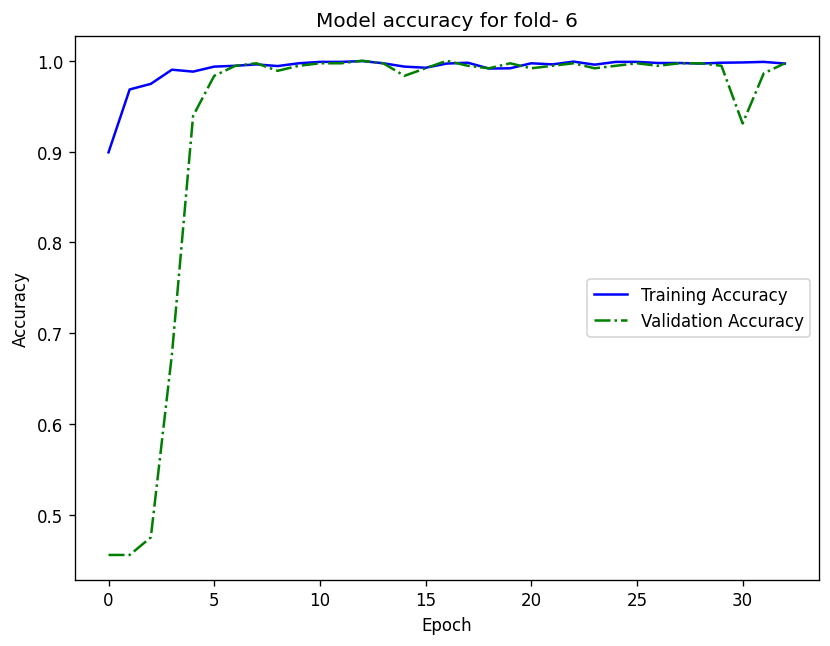

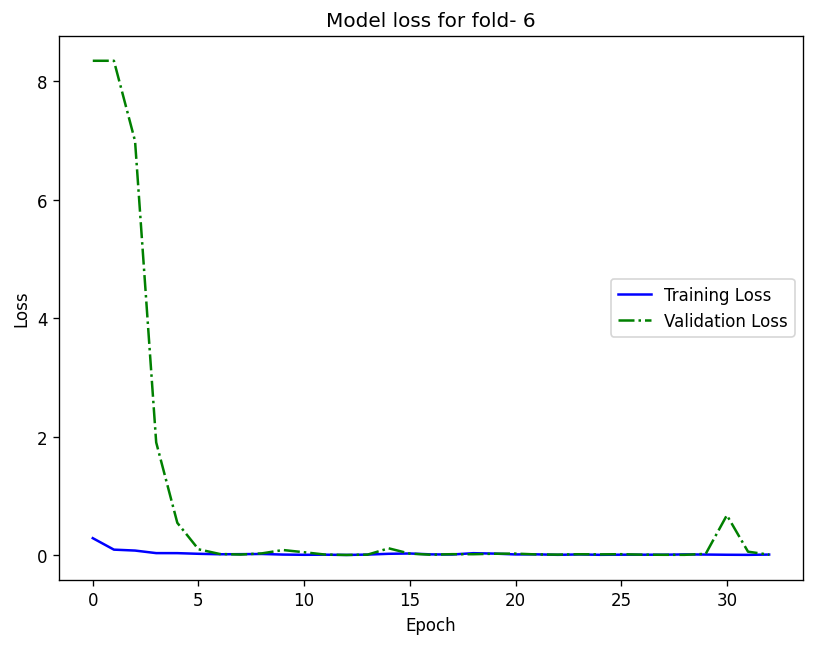

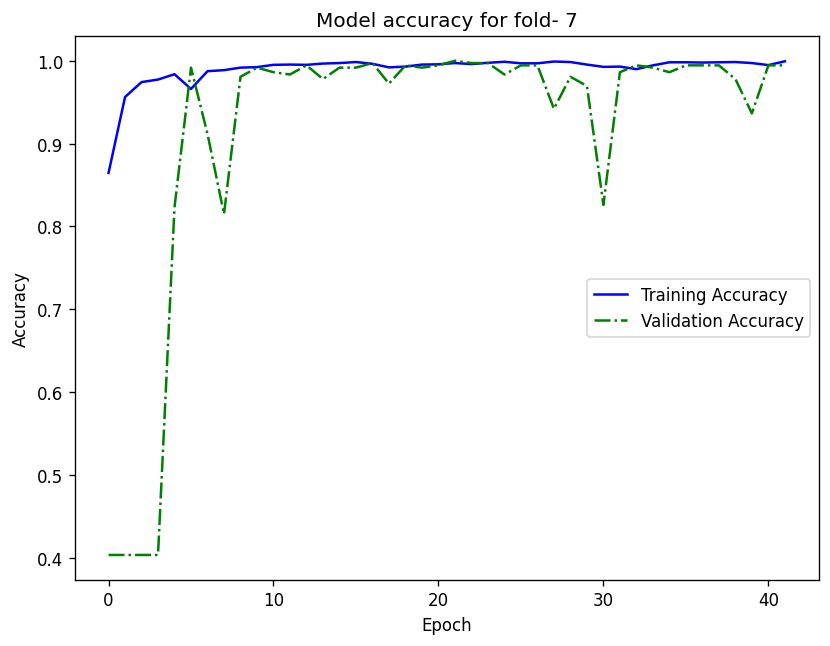

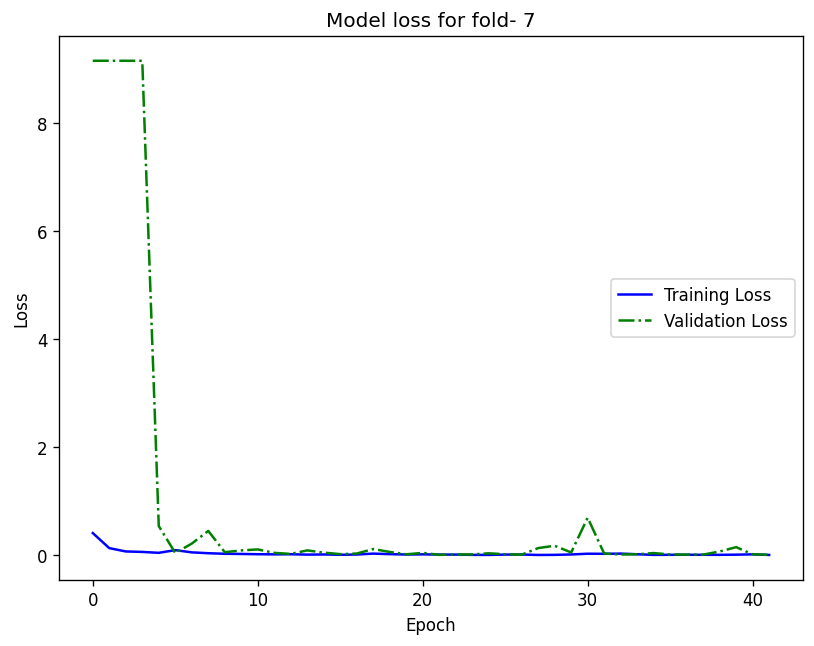

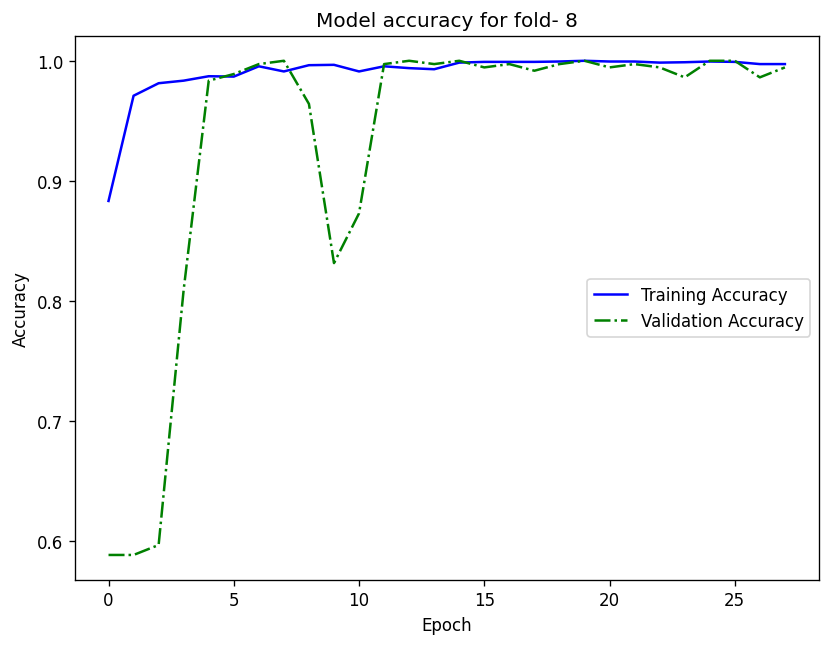

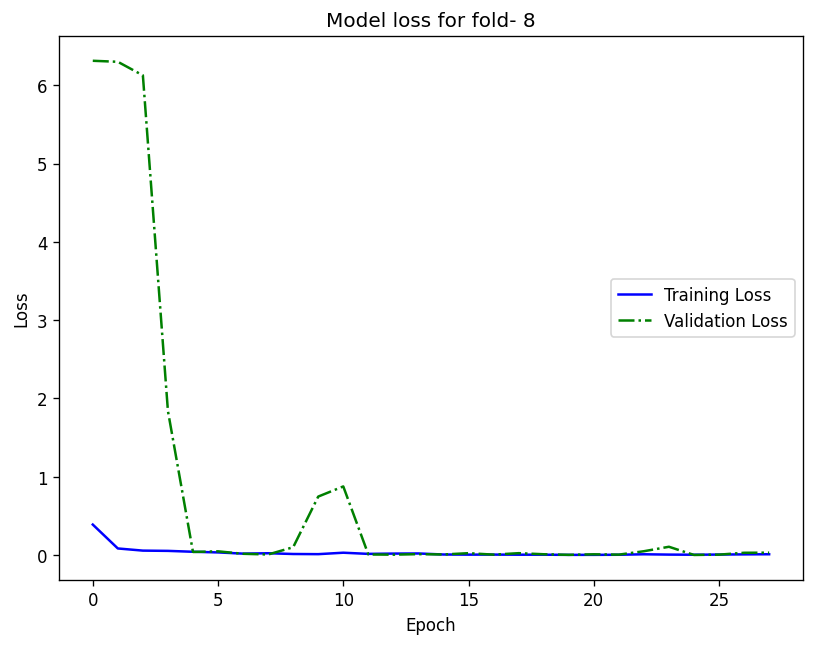

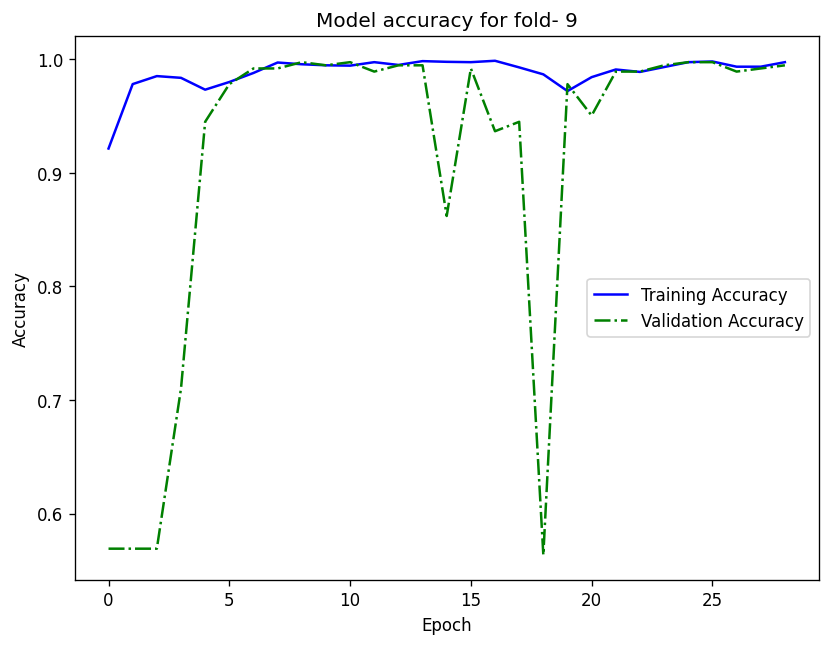

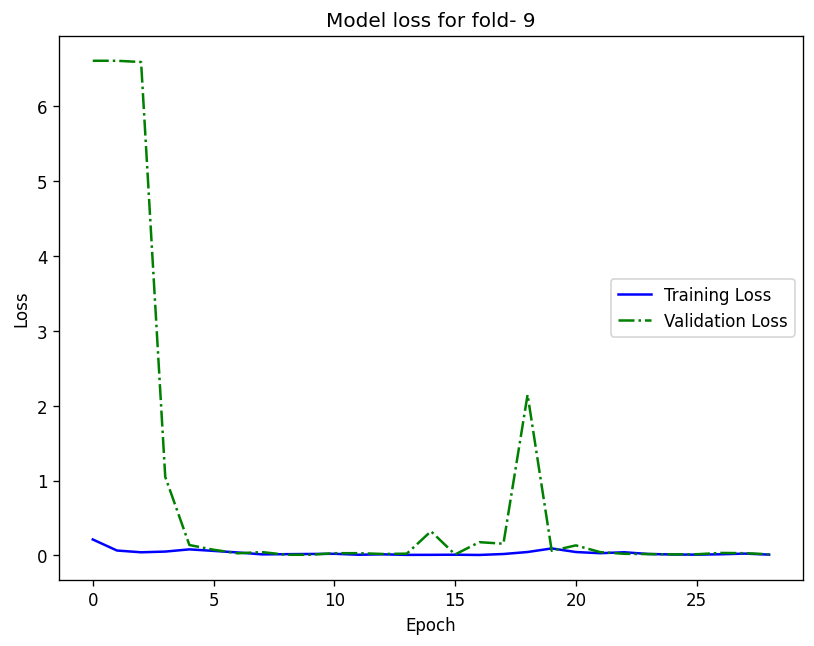

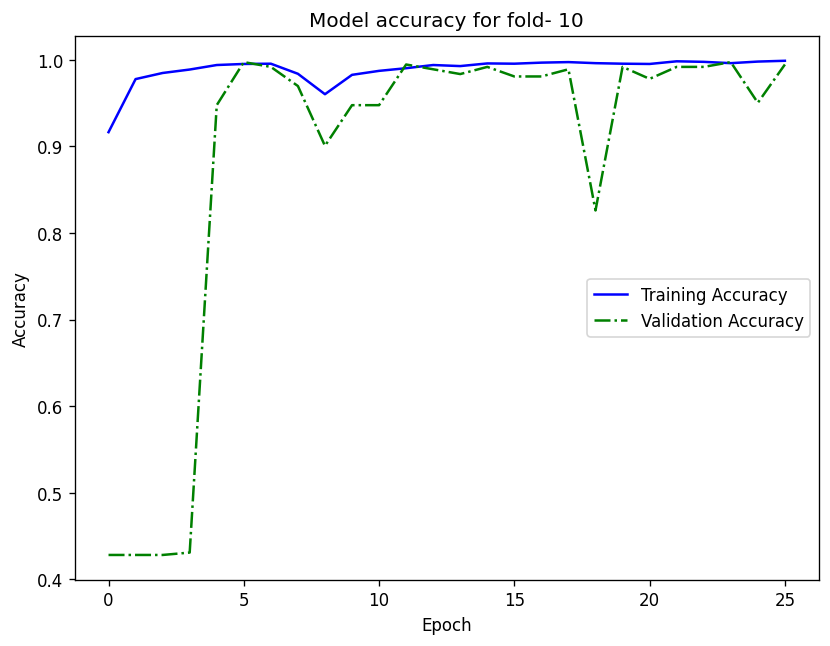

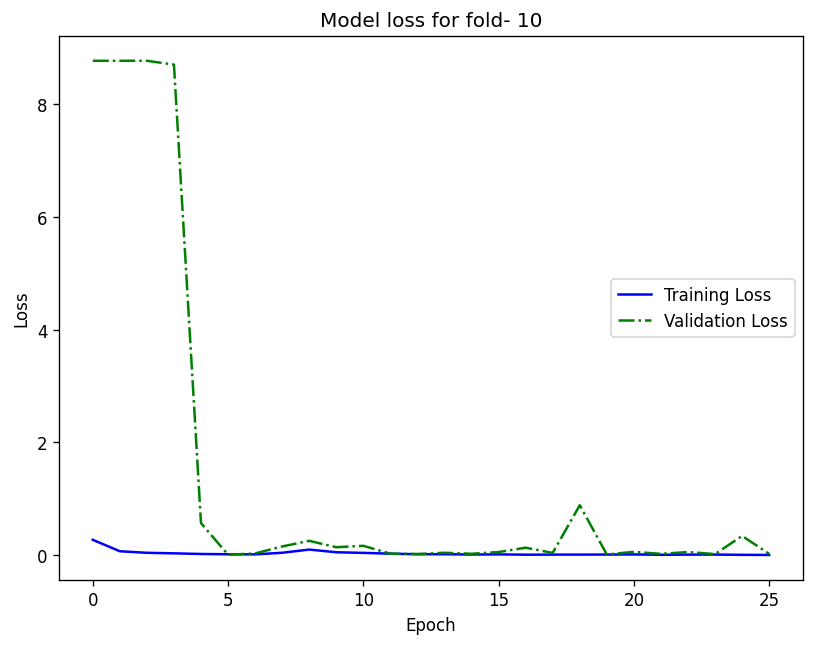